In [1]:
import os
# Find the latest version of spark 3.x  from http://www.apache.org/dist/spark/ and enter as the spark version
# For example:
# spark_version = 'spark-3.4.0'
spark_version = 'spark-3.4.3'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://www.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop3.tgz
!tar xf $SPARK_VERSION-bin-hadoop3.tgz
!pip install -q findspark

# Set Environment Variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop3"

# Start a SparkSession
import findspark
findspark.init()

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:5 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:6 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done


In [55]:
import pandas as pd
import matplotlib.pyplot as plt


import pyspark
from pyspark.sql import SparkSession
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder
import tensorflow as tf

In [12]:
# Load the data
df = pd.read_csv('/content/Amazon_Product_Reviews.csv')
df.head()

,Product ID,Product Name,Asins,Categories,Review Date,Recommended,Reviews_Helpful,Reviews_Ratings,Review_Text,Review_Title
0,AVqVGZNvQMlgsOJE6eUY,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",B00ZV9PXP2,Electronics,2017-09-03T00:00:00.000Z,False,0,3,I thought it would be as big as small paper bu...,Too small
1,AVqVGZNvQMlgsOJE6eUY,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",B00ZV9PXP2,Electronics,2017-06-06T00:00:00.000Z,True,0,5,This kindle is light and easy to use especiall...,Great light reader. Easy to use at the beach
2,AVqVGZNvQMlgsOJE6eUY,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",B00ZV9PXP2,Electronics,2018-04-20T00:00:00.000Z,True,0,4,Didnt know how much i'd use a kindle so went f...,Great for the price
3,AVqVGZNvQMlgsOJE6eUY,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",B00ZV9PXP2,Electronics,2017-11-02T17:33:31.000Z,True,3,5,I am 100 happy with my purchase. I caught it o...,A Great Buy
4,AVqVGZNvQMlgsOJE6eUY,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",B00ZV9PXP2,Electronics,2018-04-24T00:00:00.000Z,True,0,5,Solid entry level Kindle. Great for kids. Gift...,Solid entry-level Kindle. Great for kids


In [13]:
df.columns

Index(['Product ID', 'Product Name', 'Asins', 'Categories', 'Review Date',
       'Recommended', 'Reviews_Helpful', 'Reviews_Ratings', 'Review_Text',
       'Review_Title'],
      dtype='object')

In [14]:
df.drop(['Product ID', 'Asins', 'Categories', 'Reviews_Helpful'], axis=1, inplace=True)
df.head()

,Product Name,Review Date,Recommended,Reviews_Ratings,Review_Text,Review_Title
0,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",2017-09-03T00:00:00.000Z,False,3,I thought it would be as big as small paper bu...,Too small
1,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",2017-06-06T00:00:00.000Z,True,5,This kindle is light and easy to use especiall...,Great light reader. Easy to use at the beach
2,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",2018-04-20T00:00:00.000Z,True,4,Didnt know how much i'd use a kindle so went f...,Great for the price
3,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",2017-11-02T17:33:31.000Z,True,5,I am 100 happy with my purchase. I caught it o...,A Great Buy
4,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",2018-04-24T00:00:00.000Z,True,5,Solid entry level Kindle. Great for kids. Gift...,Solid entry-level Kindle. Great for kids


In [17]:
def assign_sentiment(rating):
    if rating >= 4:
        return 'positive'
    elif rating == 3:
        return 'neutral'
    else:
        return 'negative'
df['sentiment'] = df['Reviews_Ratings'].apply(assign_sentiment)
df['sentiment_num'] = df["sentiment"].map({'positive':1, 'negative':2, 'neutral':0 }).values

In [18]:
df.head()

,Product Name,Review Date,Recommended,Reviews_Ratings,Review_Text,Review_Title,sentiment,sentiment_num
0,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",2017-09-03T00:00:00.000Z,False,3,I thought it would be as big as small paper bu...,Too small,neutral,0
1,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",2017-06-06T00:00:00.000Z,True,5,This kindle is light and easy to use especiall...,Great light reader. Easy to use at the beach,positive,1
2,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",2018-04-20T00:00:00.000Z,True,4,Didnt know how much i'd use a kindle so went f...,Great for the price,positive,1
3,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",2017-11-02T17:33:31.000Z,True,5,I am 100 happy with my purchase. I caught it o...,A Great Buy,positive,1
4,"Amazon Kindle E-Reader 6"" Wifi (8th Generation...",2018-04-24T00:00:00.000Z,True,5,Solid entry level Kindle. Great for kids. Gift...,Solid entry-level Kindle. Great for kids,positive,1


Analyzing the 'Sentiment_num'

In [36]:
# Find distinct values of sentiments
df.sentiment_num.value_counts()

sentiment_num
1    4686
0     197
2     117
Name: count, dtype: int64

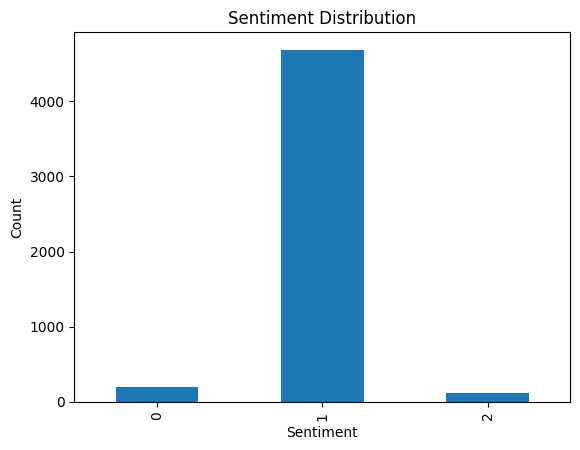

In [32]:
df['sentiment_num'].value_counts().sort_index().plot.bar()
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

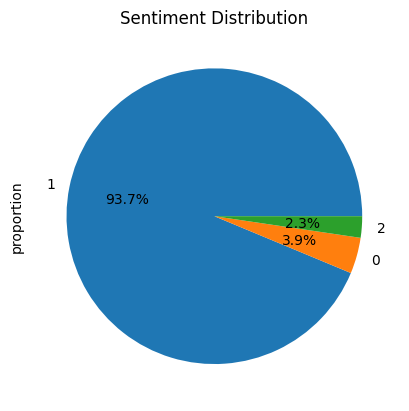

In [43]:
sentiment_percentages = df['sentiment_num'].value_counts(normalize=True) * 100
sentiment_percentages.plot.pie(autopct='%1.1f%%')
plt.title('Sentiment Distribution')
plt.show()

In [35]:
from pprint import pprint
example = df['Review_Text'][20]
pprint(example)

('I was looking for a kindle whitepaper. I saw online for $80. What a deal. I '
 "ordered it on line and picked it up in the store. I got it home and couldn't "
 'adjust the brightness. After a lengthy time with online customer service I '
 'called customer service. After 20 minuets with speaking to a female Elmer '
 "Fud that doesn't speak english well I figured I would just return it. "
 'Although it looks Identical to the $120 model, you can not adjust the '
 'brightness. That would have been good information before I bought it.')
